In [133]:
%run '../definitions.ipynb'
%run '../treemakers.ipynb'

In [134]:
%run '../Analysis_class.ipynb'

In [135]:
# Toggle data location
local_data = True

In [136]:
if local_data:
    processed_data_path = '/home/erik/win/data/xams_run8/processed/low_pmt_gain/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    processed_data_path = '/data/xenon/xams/run8/processed/data/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [137]:
run_names_na = get_run_list(processed_data_path, '170323_155714', '170323_161452')

Run list contains 3 files


In [138]:
x = XAMSAnalysis(run_names_na, processed_data_path, minitree_path)

In [139]:
x.load()

In [140]:
x.corr_pmtgains([2e6, 0, 0, 2e6, 0, 0,0,0], [700, 750], verbose=True)

Using gains 417501.174012 and 256664.096882, factors 4.790406 and 7.792286, PMT1 and 2 respectively.


## Cuts

In [141]:
x.cut_interaction_exists()

Finite s1 selection: 6127 rows removed (93.48% passed)


### Single scatter

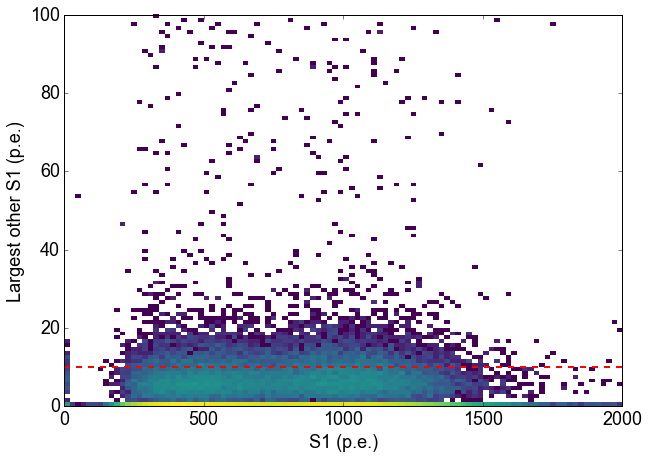

largest_other_s1 below 10 selection: 9805 rows removed (88.84% passed)


In [142]:
x.cut_largest_other_s1(largest_other_s1_max=10, plot=True, apply=True, bins=100, 
                       norm=LogNorm(), range=((0, 2000), (0, 100)))

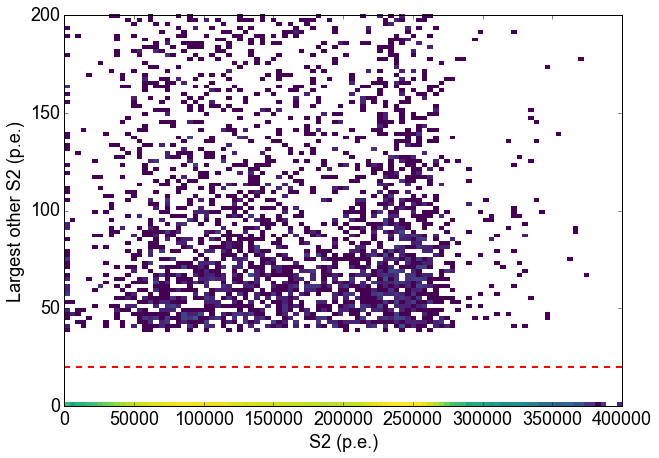

largest_other_s2 below 20 selection: 21674 rows removed (72.24% passed)


In [143]:
x.cut_largest_other_s2(largest_other_s2_max=20, 
                       plot=True, apply=True, bins=100, norm=LogNorm(), range=((0, 400e3), (0, 200)))

### Thresholds

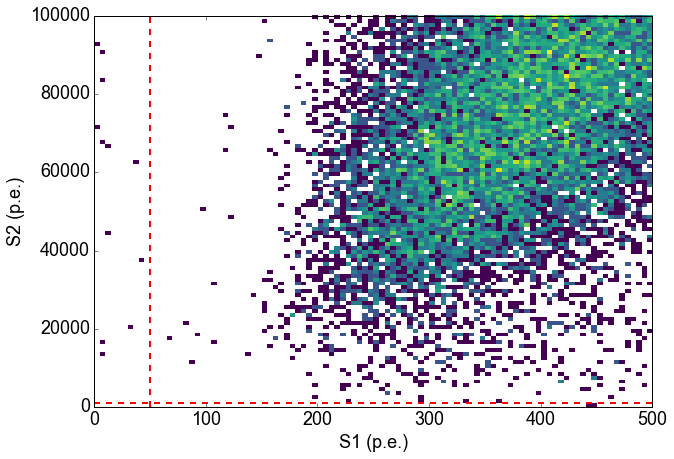

s1 above 50 selection: 25 rows removed (99.96% passed)
s2 above 1000 selection: 107 rows removed (99.81% passed)


In [144]:
x.cut_thresholds(s1_threshold=50, s2_threshold=1000,
    apply=True, plot=True, bins=100, norm=LogNorm(), range=((0, 500), (0, 100e3)))

### Saturation

In [145]:
x.cut_saturation()

s1_n_saturated_channels below 1 selection: 0 rows removed (100.00% passed)
s2_n_saturated_channels below 1 selection: 26 rows removed (99.95% passed)


### S1 AFT

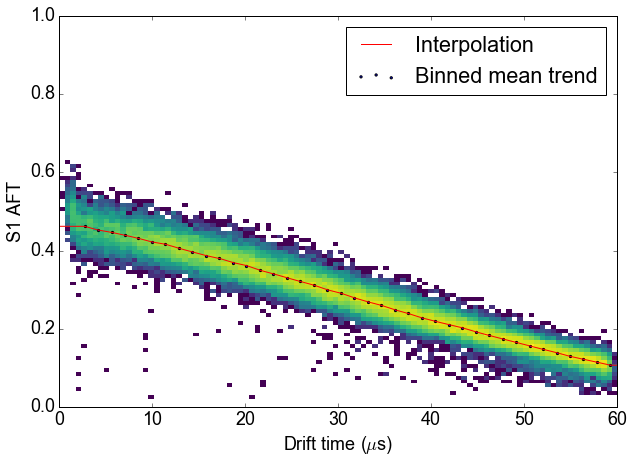

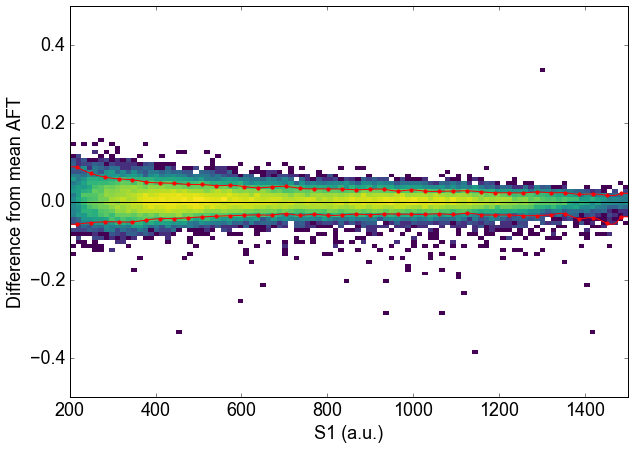

AFT_Upper selection: 2828 rows removed (94.97% passed)
AFT_Lower selection: 2899 rows removed (94.57% passed)


In [146]:
x.cut_s1_aft(plot=True, apply=True, s1_range=(200, 1500), s1_bins=40, dt_range=(2, 60), dt_bins=40)

### Drift time

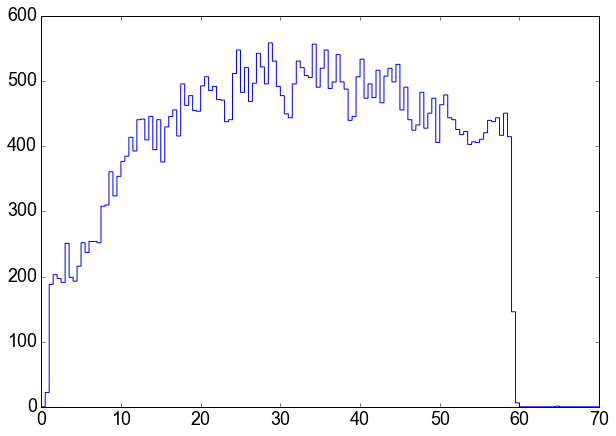

drift_time in [0, 60) selection: 1 rows removed (100.00% passed)


In [147]:
x.cut_drift_time(apply=True, plot=True, range=(0, 70), bins=140, histtype='step')

## Corrections

### Compute S1 LY correction

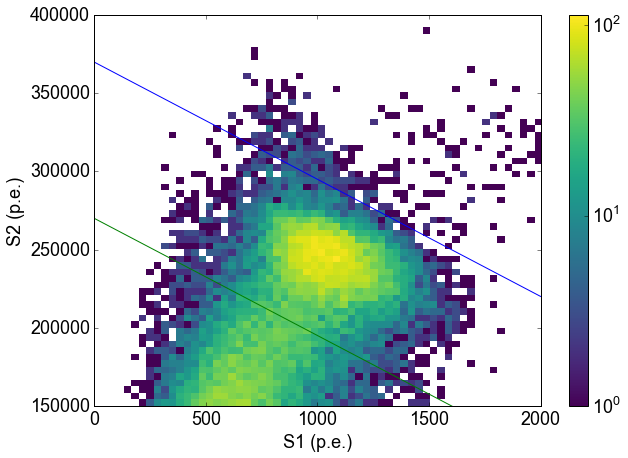

In [148]:
x.plot_s1s2(bins=60, norm=LogNorm(), range=((0, 2000), (150e3, 400e3)))
x_plot = np.linspace(0, 2e3, 10)
def upper(s1):
    return 370e3 - 75 * s1
def lower(s1):
    return 270e3 - 75 * s1
plt.plot(x_plot, upper(x_plot))
plt.plot(x_plot, lower(x_plot))
plt.colorbar()

In [149]:
d = x.d
# Select photopeak
d = d[(d['s2'] < upper(d['s1'])) & (d['s2'] > lower(d['s1']))]

In [150]:
def p2(x, a0, a1, a2):
    return a0 + a1 * x + a2 * x**2

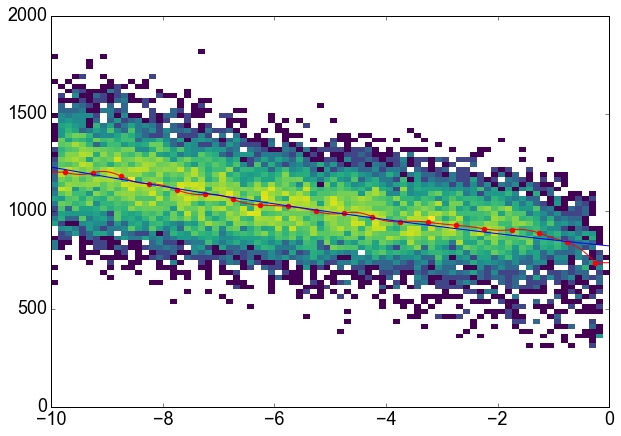

In [151]:
x1, y1 = get_trend(d['z'], d['s1'], x_range=(-10,0), bins=20)
f = my_interp(x1,y1,kind='quadratic')
popt, pcov = scipy.optimize.curve_fit(p2, d['z'], d['s1'], p0=[500, 1, 10])
pickle.dump((x1,y1), open('na22_ly.pickle', 'wb'))
pickle.dump((p2, popt, pcov), open('na22_ly_poly.pickle', 'wb'))

plt.hist2d(d['z'], d['s1'], bins=80, norm=LogNorm(), range=((-10,0), (0,2000)))
x_plot = np.linspace(-10,0, 500)
plt.plot(x_plot, f(x_plot), color='red')
plt.plot(x_plot, p2(x_plot, *popt))


plt.scatter(x1,y1, color='red')
plt.show()

### Apply S1 correction

In [152]:
x.corr_s1_ly_poly()

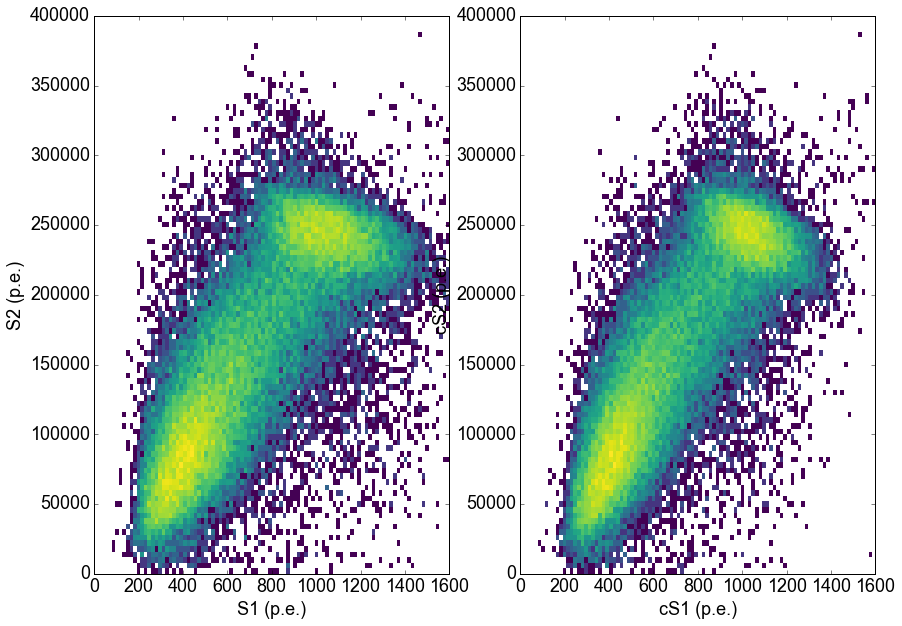

In [153]:
plt.figure(figsize=(14,10))
plt.subplot(121)
x.plot_s1s2(bins=100, range=((0,1600), (0, 400e3)), norm=LogNorm())
plt.subplot(122)
x.plot_cs1cs2(bins=100, range=((0,1600), (0, 400e3)), norm=LogNorm())

### S2 vs bottom s2

In [154]:
d=  x.d

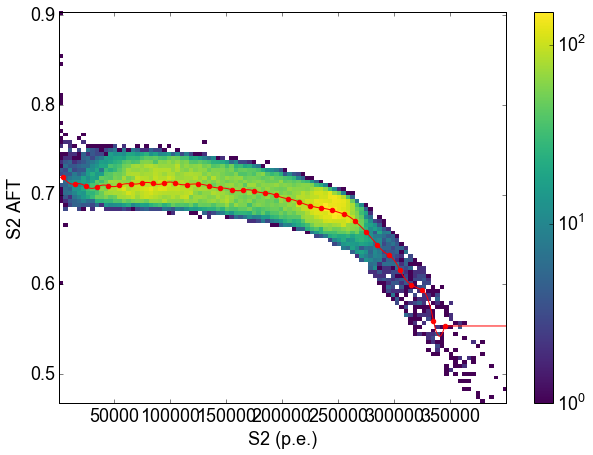

In [155]:
x1, y1 = get_trend(d['s2'], d['s2_area_fraction_top'], x_range=(0, 350e3), bins=35)
f = my_interp(x1, y1)
plt.hist2d(d['s2'], d['s2_area_fraction_top'], bins=100, norm=LogNorm())
plt.colorbar()
x_plot=np.linspace(0, 400e3, 500)
plt.plot(x_plot, f(x_plot), color='red')
plt.scatter(x1, y1, color='red')
plt.xlabel('S2 (p.e.)')
plt.ylabel('S2 AFT')
plt.show()

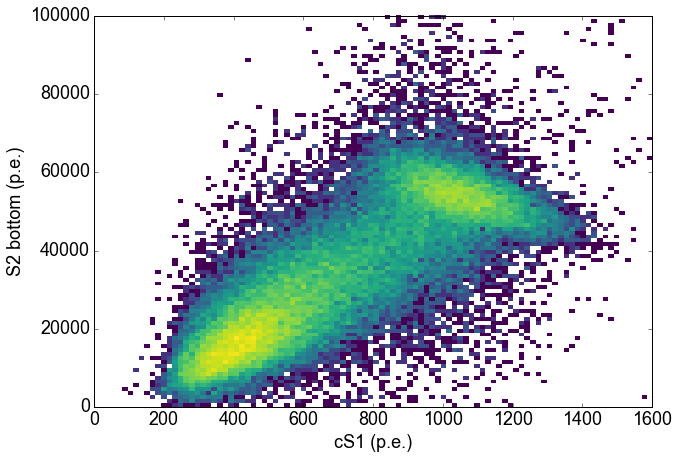

In [156]:
x.plot_cs1bs2(bins=100, range=((0, 1600), (0, 100e3)), norm=LogNorm())

## Fit

In [157]:
def build_fit_lists(x, y, x_range, y_range, x_bins, y_bins):
    x_bin_edges = np.linspace(x_range[0], x_range[1], x_bins+1)
    y_bin_edges = np.linspace(y_range[0], y_range[1], y_bins+1)
    
    
    # Loop over all bins first in x then in y and count the number of entries in that bin
    # Slightly inefficient code
    counts = []
    for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:]):
        x_sub = x[(y >= left_y) & (y < right_y)]
        for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:]):
            counts.append(sum((x_sub >= left_x) & (x_sub < right_x)))
    
    
    
    x_list = [0.5*(left_x + right_x)
              for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:])
              for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:])
              ]
    y_list = [0.5*(left_y + right_y)
              for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:])
              for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:])
              ]
    
    return np.array(counts), np.array(x_list), np.array(y_list)

In [158]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g #.ravel()

### Build lists

In [159]:
d = x.d
pickle.dump(d, open('./fit2d_mwe/d.pickle', 'wb'))

In [160]:
cs1_range = (700, 1500)
cs2_range = (40e3, 70e3)
cs1_bins = 40
cs2_bins = 40


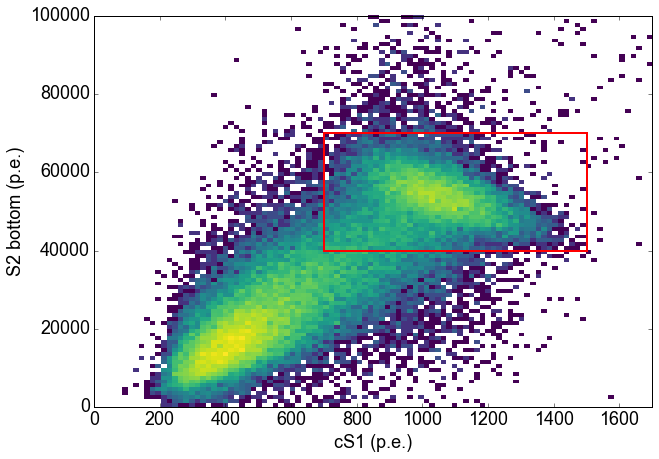

In [161]:
x.plot_cs1bs2(bins=100, norm=LogNorm(), range=((0, 1700), (0, 100e3)))
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)

In [162]:
counts, x_fit, y_fit = build_fit_lists(d['cs1'], d['s2_bot'], cs1_range, cs2_range, cs1_bins, cs2_bins)

In [163]:

def cut1(x):
    return 80e3 - 35*x   
def cut2(x):
    return 100e3 - 35*x  


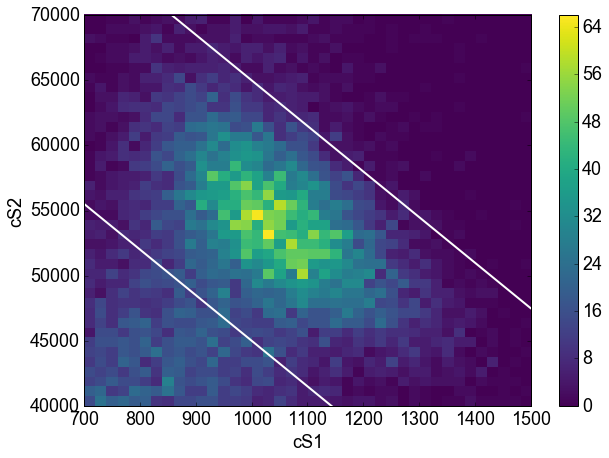

In [164]:
plt.hist2d(d['cs1'], d['s2_bot'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())

x_plot = np.linspace(*cs1_range, num=20)
for cut in [cut1, cut2]:
    plt.plot(x_plot, cut(x_plot), color='white', lw=2)
plt.colorbar()
plt.xlabel('cS1')
plt.ylabel('cS2')
plt.show()

In [165]:
sel = (cut1(x_fit) < y_fit) & (cut2(x_fit) > y_fit)

In [166]:
initial_guess = (70,1000,55000,30,2000,-0.03,0)
popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x_fit[sel], y_fit[sel]), counts[sel], p0=initial_guess)
print('cS1 peak position: %.1f' % (popt[1]))
print('cS2 peak position: %.1f' % (popt[2]))

cS1 peak position: 1036.4
cS2 peak position: 53889.5


In [167]:
delta1 = 1
delta2 = 100
x = np.arange(*cs1_range, step=delta1)
y = np.arange(*cs2_range, step=delta2)

X, Y = np.meshgrid(x, y)
Z = twoD_Gaussian((X,Y), *popt)

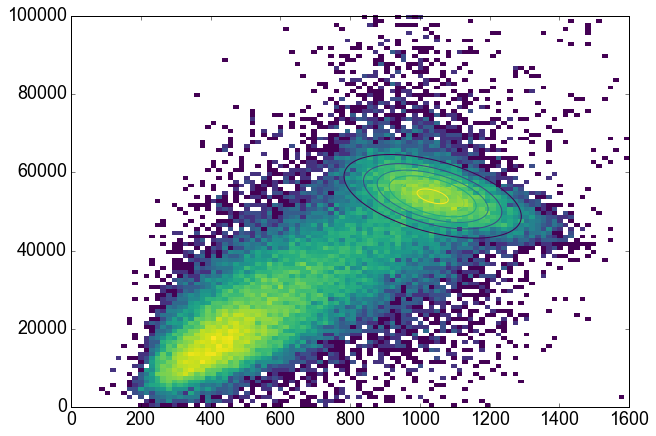

In [168]:
plt.hist2d(d['cs1'], d['s2_bot'], bins=100, norm=LogNorm(), range=((0, 1600),(0, 100e3)))

plt.contour(X, Y, Z)

plt.show()